## **Stock Price Forecasting**

## Objective
A company’s stock price is a potent indicator of the company's health, reflecting investor confidence in its ability to weather economic storms, innovate, and deliver shareholder value. Accurately predicting its movements empowers investors to make good decisions, hedge against risks, and capitalize on potential opportunities. This project aims to predict the daily stock price of Boeing company in Nasdaq stock market with a small datset, wich is useful when dealing with companies that have been listed on the stock market for less than 3 years.

## Data Source & Size
The data for this project comes from Yahoo Finance platform which aggregates data from different stock markets.

Link to dataset: https://finance.yahoo.com/quote/BA/history/

This dataset contains 943 rows and 6 columns.

## Data Dictionary
- Open: the opening price of the stock on the given date
- High: the highest price at which the stock traded during the course of the day
- Low: the lowest price at which the stock traded during the course of the day
- Close: the closing price of the stock on the given date
- Volume: the number of shares that changed hands during the given day
- Adj_Close: the closing price of the stock that has been adjusted to include any corporate actions

## Methodologie
We will explore and clean the dataset, then, we will use two univariate models to predict the daily stock prices. Performance will be evaluated based on sevral metric like r2 and mse scores.

## Imports

In [1]:
# imports
import warnings
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tabulate import tabulate

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Configuring General Settings 

In [2]:
# general settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Loading Data

In [3]:
# import data
ticker = "BA"
df_boeing = yf.download(ticker, start="2020-01-01", end="2023-10-01")

[*********************100%%**********************]  1 of 1 completed


## EDA & Data Cleaning

In [4]:
print("Data Shape:", df_boeing.shape)
df_boeing.head()

Data Shape: (943, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,328.549988,333.350006,327.700012,333.320007,331.348572,4544400
2020-01-03,330.630005,334.890015,330.299988,332.760010,330.791901,3875900
2020-01-06,329.299988,334.859985,327.880005,333.739990,331.766083,5355000
2020-01-07,334.260010,344.190002,330.709991,337.279999,335.285156,9898600
2020-01-08,332.399994,334.029999,329.600006,331.369995,329.410095,8239200


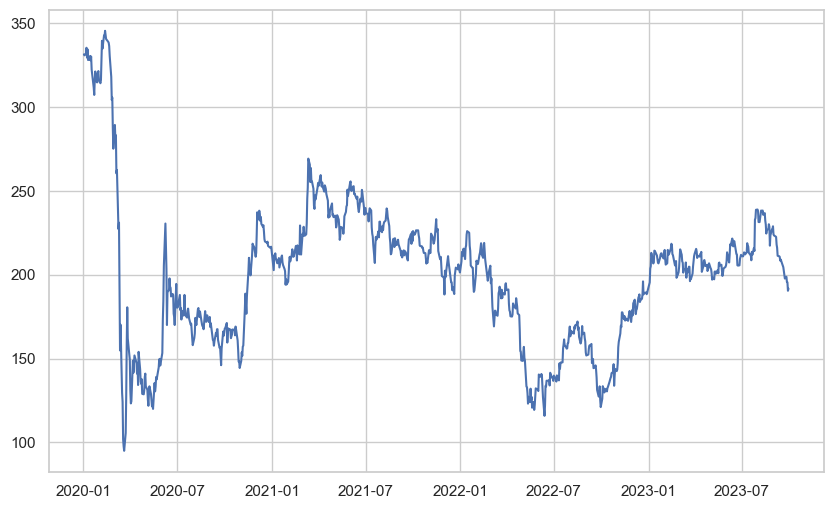

In [11]:
plt.figure(figsize=(10,6))
plt.plot(df_boeing["Adj Close"])

The daily Boeing stock price process is not stationary and it dosen't represent a well defined trend and seasonality

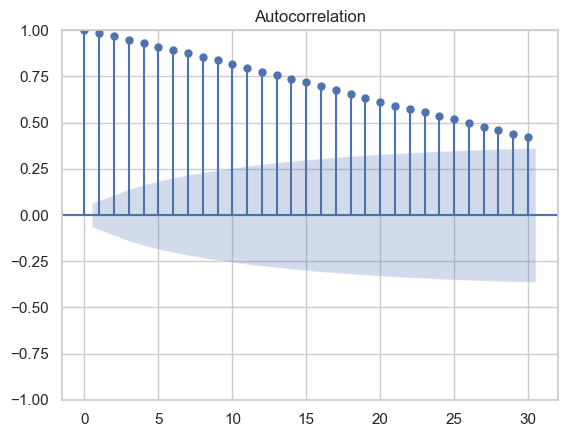

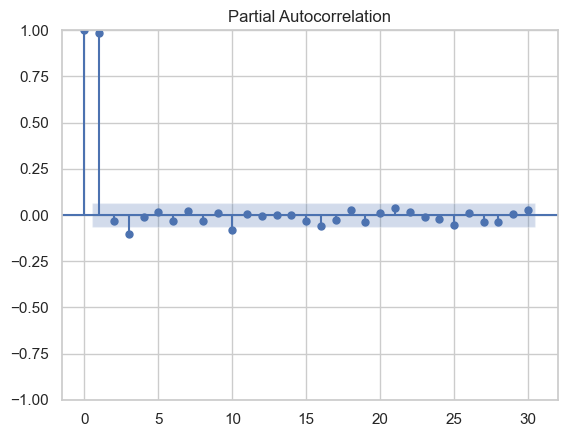

In [12]:
plot_acf(df_boeing["Adj Close"])
plot_pacf(df_boeing["Adj Close"])
plt.show()

We see that the autocorrelation function decrease progressively over lags which not allow us the fix the MA order. On the other hand the partial autocorrelation decrease dramatically from 1 lag so we can fix the AR order to 1.

In [13]:
# interpolate missing raws
df_adj_close = df_boeing["Adj Close"]
start_date = df_adj_close.index.min()
end_date = df_adj_close.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='D')
df_adj_close = df_adj_close.reindex(full_index)
df_adj_close.interpolate(inplace=True)

## Modeling & Evaluation

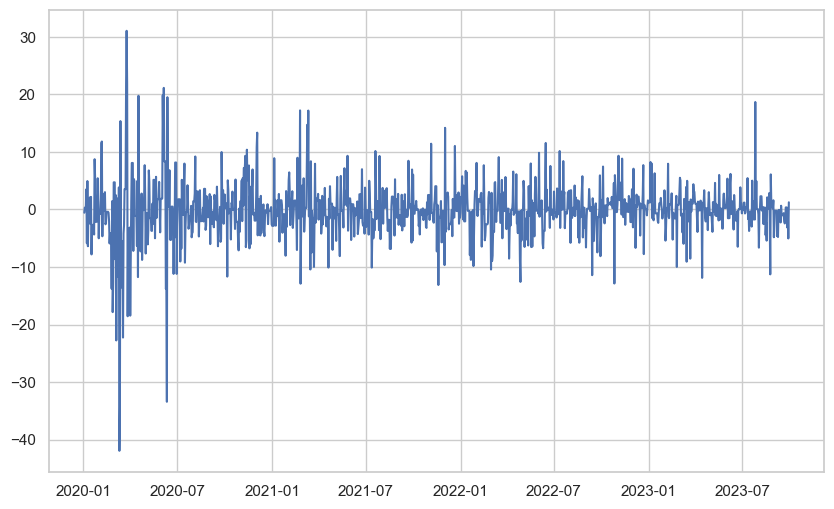

In [14]:
plt.figure(figsize=(10,6))
plt.plot(df_adj_close.diff(1).dropna())

The process trend was removed after applying an integration to order 1, so we can fix the integration order to 1.

In [10]:
# train-test split data for the ARIMA model
df_train = df_adj_close[:-300]
df_test = df_adj_close[-300:]

In [11]:
# try different MA orders
for i in range(5):
    arima_model = ARIMA(df_train, order=(1,1,i))
    arima_model_fit = arima_model.fit()
    print(f"* MA order = {i}\n{arima_model_fit.summary()}")

* MA order = 0
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1067
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3227.175
Date:                Tue, 16 Jan 2024   AIC                           6458.349
Time:                        00:39:56   BIC                           6468.293
Sample:                    01-02-2020   HQIC                          6462.117
                         - 12-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.012     12.918      0.000       0.129       0.176
sigma2        24.9491      0.429     58.113      0.000      24.108      25.791
Ljung-Box (L1) (Q):                  

The overall best MA order is 1

In [20]:
# 7 steps forecast with the ARIMA model
start = df_train.shape[0]-1
ends_list = [start+7*i for i in range(df_test.shape[0]//7)]
predict_list = []
for i in ends_list:
    arima_model = ARIMA(df_adj_close.iloc[:i], order=(1,1,1))
    arima_model_fit = arima_model.fit()
    predict_list = predict_list + arima_model_fit.forecast(7).to_list()

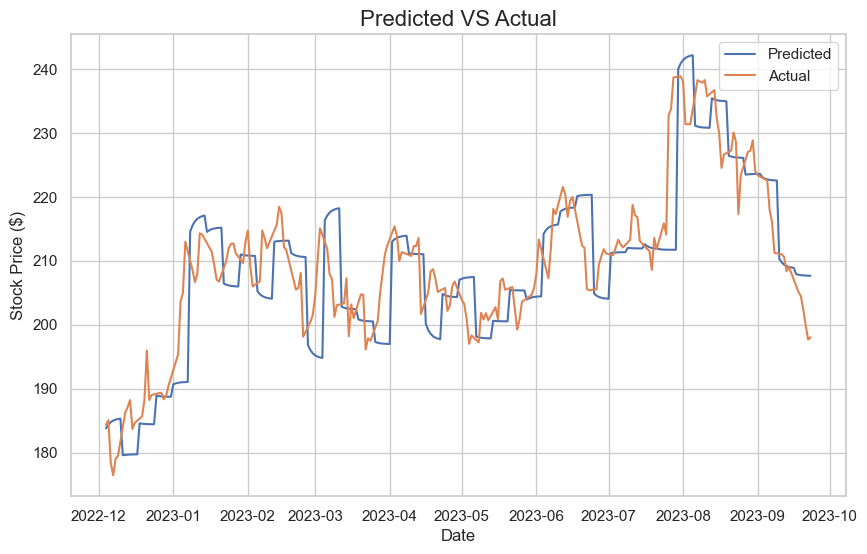

In [21]:
# plot predicted and actual values for the Prophet model
plt.figure(figsize=(10,6))
plt.plot(df_test[:len(predict_list)].index, predict_list, label="Predicted")
plt.plot(df_test[:len(predict_list)], label="Actual")
plt.title("Predicted VS Actual", size=16)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

In [13]:
def regression_metrics_ARMA(model, y_train, y_test, y_test_pred) :
    start_train = y_train.index[0]
    end_train = y_train.index[-1]
    y_test = y_test[:len(y_test_pred)]
    y_train_pred = model.predict(start=start_train, end=end_train)
    tab = tabulate([["Metric","Training Set","Test Set"],
                  ["r2",r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred)],
                  ["MSE",mean_squared_error(y_train,y_train_pred),mean_squared_error(y_test,y_test_pred)],
                  ["MAE",mean_absolute_error(y_train,y_train_pred),mean_absolute_error(y_test,y_test_pred)],
                  ["RMSE",mean_squared_error(y_train,y_train_pred,squared=False),mean_squared_error(y_test,y_test_pred,squared=False)]],
                headers='firstrow',numalign="left")
    return tab
print(regression_metrics_ARMA(arima_model_fit, df_train, df_test, predict_list))

Metric    Training Set    Test Set
--------  --------------  ----------
r2        0.945446        0.685585
MSE       127.578         46.8403
MAE       3.43714         4.95285
RMSE      11.295          6.844


- The r2 score shows that the ARIMA model has explained 68% the testing data variance.
- Depending on the MAE score, the model tends to make an error of about 5$, and since the root mean squared error is not significantly higher than the mean absolute error, this shows us that the errors have a close values.

In [14]:
# train-test split data for the Prophet model
df_prophet = df_adj_close.reset_index()
df_prophet["index"] = pd.to_datetime(df_prophet["index"])
df_prophet.columns = ["ds","y"]
df_train_prophet = df_prophet.iloc[:-300]
df_test_prophet = df_prophet.iloc[-300:]

In [27]:
# 7 steps forecast with the Prophet model
start = df_train.shape[0]-1
ends_list = [start+7*i for i in range(df_test.shape[0]//7)]
predict_list_prophet = []
for i in ends_list:
    prophet_model = Prophet()
    prophet_model.fit(df_prophet.iloc[:i])
    future = prophet_model.make_future_dataframe(periods=7, include_history=False)
    predict_list_prophet = predict_list_prophet + prophet_model.predict(future)["yhat"].to_list()

01:22:55 - cmdstanpy - INFO - Chain [1] start processing
01:22:55 - cmdstanpy - INFO - Chain [1] done processing
01:22:56 - cmdstanpy - INFO - Chain [1] start processing
01:22:57 - cmdstanpy - INFO - Chain [1] done processing
01:22:57 - cmdstanpy - INFO - Chain [1] start processing
01:22:58 - cmdstanpy - INFO - Chain [1] done processing
01:22:58 - cmdstanpy - INFO - Chain [1] start processing
01:22:59 - cmdstanpy - INFO - Chain [1] done processing
01:22:59 - cmdstanpy - INFO - Chain [1] start processing
01:23:00 - cmdstanpy - INFO - Chain [1] done processing
01:23:01 - cmdstanpy - INFO - Chain [1] start processing
01:23:01 - cmdstanpy - INFO - Chain [1] done processing
01:23:02 - cmdstanpy - INFO - Chain [1] start processing
01:23:03 - cmdstanpy - INFO - Chain [1] done processing
01:23:03 - cmdstanpy - INFO - Chain [1] start processing
01:23:04 - cmdstanpy - INFO - Chain [1] done processing
01:23:05 - cmdstanpy - INFO - Chain [1] start processing
01:23:05 - cmdstanpy - INFO - Chain [1]

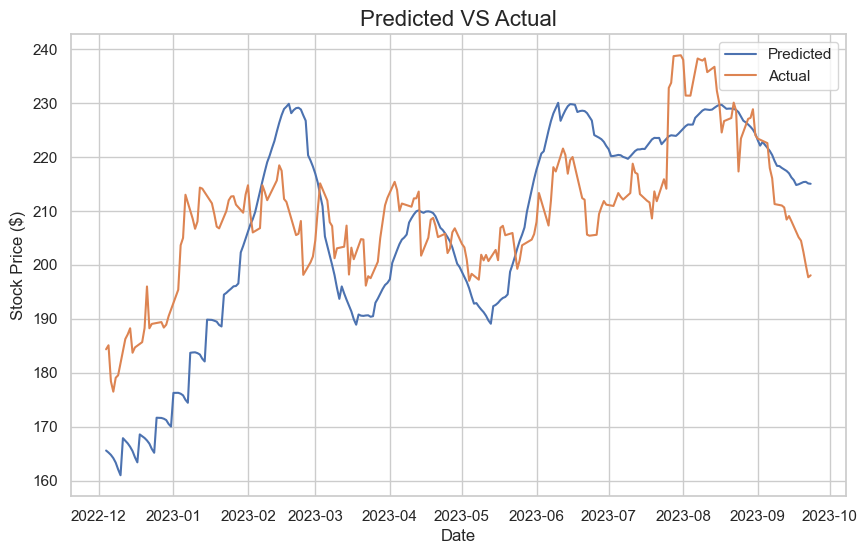

In [32]:
# plot predicted and actual values for the Prophet model
plt.figure(figsize=(10,6))
plt.plot(df_test_prophet["ds"][:len(predict_list_prophet)], predict_list_prophet, label="Predicted")
plt.plot(df_test_prophet["ds"][:len(predict_list_prophet)], df_test_prophet["y"][:len(predict_list_prophet)], label="Actual")
plt.title("Predicted VS Actual", size=16)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

In [31]:
y_train = df_train_prophet["y"]
y_test = df_test_prophet["y"][:len(predict_list_prophet)]
y_train_pred = prophet_model.predict(df_train_prophet)["yhat"]
tab = tabulate([["Metric", "Training Set","Test Set"],
                  ["r2", r2_score(y_train, y_train_pred), r2_score(y_test, predict_list_prophet)],
                  ["MSE", mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, predict_list_prophet)],
                  ["MAE", mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, predict_list_prophet)],
                  ["RMSE", mean_squared_error(y_train, y_train_pred, squared=False),
                   mean_squared_error(y_test, predict_list_prophet, squared=False)]],
                headers='firstrow', numalign="left")
   
print(tab)

Metric    Training Set    Test Set
--------  --------------  ----------
r2        0.861955        -0.157648
MSE       322.827         172.462
MAE       13.166          10.9402
RMSE      17.9674         13.1325


- The r2 score shows that the Prophet model has failed to explain the data variance.
- Depending on the MAE score, the model tends to make an error of about 11$, and since the root mean squared error is not significantly higher than the mean absolute error, this shows us that the errors have a close values.

Depnding on all the used scores, The ARIMA model has a better performance. 

## Recommandations
- The use of the ARIMA model to forecast the daily stock price is reliable for an horizon of 7 days and an error tolerance of 5$.
- Regardless the prformance of this model, It is important to take in consideration any events that can affect the stock price such a pandemic or economic crisis, befor taking any decision.

## Limitations & Next Steps
For an horizon of more than 7 days the model could not be very reliable so to improve its performance for a higher horizons we can add other features like economic indicators and try to combine different models.